# Coursework 1 :
See pdf for instructions. 

In [2]:
import numpy as np 
import random
import matplotlib.pyplot as plt 


In [1]:
# WARNING: fill in these two functions that will be used by the auto-marking script
# [Action required]

def get_CID():
  return "01731629" # Return your CID (add 0 at the beginning to ensure it is 8 digits long)

def get_login():
  return "mrb23" # Return your short imperial login

## Helper class

In [4]:
# This class is used ONLY for graphics
# YOU DO NOT NEED to understand it to work on this coursework

class GraphicsMaze(object):

  def __init__(self, shape, locations, default_reward, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):

    self.shape = shape
    self.locations = locations
    self.absorbing = absorbing

    # Walls
    self.walls = np.zeros(self.shape)
    for ob in obstacle_locs:
      self.walls[ob] = 20

    # Rewards
    self.rewarders = np.ones(self.shape) * default_reward
    for i, rew in enumerate(absorbing_locs):
      self.rewarders[rew] = 10 if absorbing_rewards[i] > 0 else -10

    # Print the map to show it
    self.paint_maps()

  def paint_maps(self):
    """
    Print the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders)
    plt.show()

  def paint_state(self, state):
    """
    Print one state on the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    states = np.zeros(self.shape)
    states[state] = 30
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders + states)
    plt.show()

  def draw_deterministic_policy(self, Policy):
    """
    Draw a deterministic policy
    input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, action in enumerate(Policy):
      if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
        continue
      arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
      action_arrow = arrows[action] # Take the corresponding action
      location = self.locations[state] # Compute its location on graph
      plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    plt.show()

  def draw_policy(self, Policy):
    """
    Draw a policy (draw an arrow in the most probable direction)
    input: Policy {np.array} -- policy to draw as probability
    output: /
    """
    deterministic_policy = np.array([np.argmax(Policy[row,:]) for row in range(Policy.shape[0])])
    self.draw_deterministic_policy(deterministic_policy)

  def draw_value(self, Value):
    """
    Draw a policy value
    input: Value {np.array} -- policy values to draw
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, value in enumerate(Value):
      if(self.absorbing[0, state]): # If it is an absorbing state, don't plot any value
        continue
      location = self.locations[state] # Compute the value location on graph
      plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    plt.show()

  def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple deterministic policies
    input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Policies)): # Go through all policies
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, action in enumerate(Policies[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
          continue
        arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
        action_arrow = arrows[action] # Take the corresponding action
        location = self.locations[state] # Compute its location on graph
        plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
    plt.show()

  def draw_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policies (draw an arrow in the most probable direction)
    input: Policy {np.array} -- array of policies to draw as probability
    output: /
    """
    deterministic_policies = np.array([[np.argmax(Policy[row,:]) for row in range(Policy.shape[0])] for Policy in Policies])
    self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

  def draw_value_grid(self, Values, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policy values
    input: Values {np.array of np.array} -- array of policy values to draw
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Values)): # Go through all values
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, value in enumerate(Values[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
          continue
        location = self.locations[state] # Compute the value location on graph
        plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
    plt.show()


## Maze class

In [5]:
# This class define the Maze environment

class Maze(object):

  # [Action required]
  def __init__(self, prob_success = 0.8 + 0.02 * (9 -  int(get_CID()[-2])), gamma = 0.8 + 0.02 * (int(get_CID()[-2]))):
    """
    Maze initialisation.
    input: /
    output: /
    """
    
    # [Action required]
    # Properties set from the CID
    self._prob_success = prob_success # float
    self._gamma = gamma # float
    self._goal = int(get_CID()[-1]) % 4 # integer (0 for R0, 1 for R1, 2 for R2, 3 for R3)

    # Build the maze
    self._build_maze()
                              

  # Functions used to build the Maze environment 
  # You DO NOT NEED to modify them
  def _build_maze(self):
    """
    Maze initialisation.
    input: /
    output: /
    """

    # Properties of the maze
    self._shape = (13, 10)
    self._obstacle_locs = [
                          (1,0), (1,1), (1,2), (1,3), (1,4), (1,7), (1,8), (1,9), \
                          (2,1), (2,2), (2,3), (2,7), \
                          (3,1), (3,2), (3,3), (3,7), \
                          (4,1), (4,7), \
                          (5,1), (5,7), \
                          (6,5), (6,6), (6,7), \
                          (8,0), \
                          (9,0), (9,1), (9,2), (9,6), (9,7), (9,8), (9,9), \
                          (10,0)
                         ] # Location of obstacles
    self._absorbing_locs = [(2,0), (2,9), (10,1), (12,9)] # Location of absorbing states
    self._absorbing_rewards = [ (500 if (i == self._goal) else -50) for i in range (4) ] #Reward of absorbing states
    self._starting_locs = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9)] 
    self._default_reward = -1 # Reward for each action performs in the environment
    self._max_t = 500 # Max number of steps in the environment

    # Actions
    self._action_size = 4
    self._direction_names = ['N','E','S','W'] # Direction 0 is 'N', 1 is 'E' and so on
        
    # States
    self._locations = []
    for i in range (self._shape[0]):
      for j in range (self._shape[1]):
        loc = (i,j) 
        # Adding the state to locations if it is no obstacle
        if self._is_location(loc):
          self._locations.append(loc)
    self._state_size = len(self._locations)

    # Neighbours - each line is a state, ranked by state-number, each column is a direction (N, E, S, W)
    self._neighbours = np.zeros((self._state_size, 4)) 
    
    for state in range(self._state_size):
      loc = self._get_loc_from_state(state)

      # North
      neighbour = (loc[0]-1, loc[1]) # North neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('N')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('N')] = state

      # East
      neighbour = (loc[0], loc[1]+1) # East neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('E')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('E')] = state

      # South
      neighbour = (loc[0]+1, loc[1]) # South neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('S')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('S')] = state

      # West
      neighbour = (loc[0], loc[1]-1) # West neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('W')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('W')] = state

    # Absorbing
    self._absorbing = np.zeros((1, self._state_size))
    for a in self._absorbing_locs:
      absorbing_state = self._get_state_from_loc(a)
      self._absorbing[0, absorbing_state] = 1

    # Transition matrix
    self._T = np.zeros((self._state_size, self._state_size, self._action_size)) # Empty matrix of dimension S*S*A
    for action in range(self._action_size):
      for outcome in range(4): # For each direction (N, E, S, W)
        # The agent has prob_success probability to go in the correct direction
        if action == outcome:
          prob = 1 - 3.0 * ((1.0 - self._prob_success) / 3.0) # (theoritically equal to self.prob_success but avoid rounding error and garanty a sum of 1)
        # Equal probability to go into one of the other directions
        else:
          prob = (1.0 - self._prob_success) / 3.0
          
        # Write this probability in the transition matrix
        for prior_state in range(self._state_size):
          # If absorbing state, probability of 0 to go to any other states
          if not self._absorbing[0, prior_state]:
            post_state = self._neighbours[prior_state, outcome] # Post state number
            post_state = int(post_state) # Transform in integer to avoid error
            self._T[prior_state, post_state, action] += prob

    # Reward matrix
    self._R = np.ones((self._state_size, self._state_size, self._action_size)) # Matrix filled with 1
    self._R = self._default_reward * self._R # Set default_reward everywhere
    for i in range(len(self._absorbing_rewards)): # Set absorbing states rewards
      post_state = self._get_state_from_loc(self._absorbing_locs[i])
      self._R[:,post_state,:] = self._absorbing_rewards[i]

    # Creating the graphical Maze world
    self._graphics = GraphicsMaze(self._shape, self._locations, self._default_reward, self._obstacle_locs, self._absorbing_locs, self._absorbing_rewards, self._absorbing)
    
    # Reset the environment
    self.reset()


  def _is_location(self, loc):
    """
    Is the location a valid state (not out of Maze and not an obstacle)
    input: loc {tuple} -- location of the state
    output: _ {bool} -- is the location a valid state
    """
    if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0]-1 or loc[1] > self._shape[1]-1):
      return False
    elif (loc in self._obstacle_locs):
      return False
    else:
      return True


  def _get_state_from_loc(self, loc):
    """
    Get the state number corresponding to a given location
    input: loc {tuple} -- location of the state
    output: index {int} -- corresponding state number
    """
    return self._locations.index(tuple(loc))


  def _get_loc_from_state(self, state):
    """
    Get the state number corresponding to a given location
    input: index {int} -- state number
    output: loc {tuple} -- corresponding location
    """
    return self._locations[state]

  # Getter functions used only for DP agents
  # You DO NOT NEED to modify them
  def get_T(self):
    return self._T

  def get_R(self):
    return self._R

  def get_absorbing(self):
    return self._absorbing

  # Getter functions used for DP, MC and TD agents
  # You DO NOT NEED to modify them
  def get_graphics(self):
    return self._graphics

  def get_action_size(self):
    return self._action_size

  def get_state_size(self):
    return self._state_size

  def get_gamma(self):
    return self._gamma

  # Functions used to perform episodes in the Maze environment
  def reset(self):
    """
    Reset the environment state to one of the possible starting states
    input: /
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """
    self._t = 0
    self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
    self._reward = 0
    self._done = False
    return self._t, self._state, self._reward, self._done

  def step(self, action):
    """
    Perform an action in the environment
    input: action {int} -- action to perform
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """

    # If environment already finished, print an error
    if self._done or self._absorbing[0, self._state]:
      print("Please reset the environment")
      return self._t, self._state, self._reward, self._done

    # Drawing a random number used for probaility of next state
    probability_success = random.uniform(0,1)

    # Look for the first possible next states (so get a reachable state even if probability_success = 0)
    new_state = 0
    while self._T[self._state, new_state, action] == 0: 
      new_state += 1
    assert self._T[self._state, new_state, action] != 0, "Selected initial state should be probability 0, something might be wrong in the environment."

    # Find the first state for which probability of occurence matches the random value
    total_probability = self._T[self._state, new_state, action]
    while (total_probability < probability_success) and (new_state < self._state_size-1):
     new_state += 1
     total_probability += self._T[self._state, new_state, action]
    assert self._T[self._state, new_state, action] != 0, "Selected state should be probability 0, something might be wrong in the environment."
    
    # Setting new t, state, reward and done
    self._t += 1
    self._reward = self._R[self._state, new_state, action]
    self._done = self._absorbing[0, new_state] or self._t > self._max_t
    self._state = new_state
    return self._t, self._state, self._reward, self._done

## DP Agent

In [6]:
# This class define the Dynamic Programing agent 

class DP_agent(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """
    Solve a given Maze environment using Dynamic Programming
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - V {np.array} -- Corresponding value function 
    """
    
    # Initialisation (can be edited)
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    epochs = 0
    policy_stable = False

    #Policy improvement
    while not policy_stable:
      V, epoch = self.policy_evaluation(policy, env)
      epochs += epoch
      policy_stable = True
      for prev_state in range(env.get_state_size()):
        if not env.get_absorbing()[0, prev_state]:
          prev_action = np.argmax(policy[prev_state, :])
          Q = np.zeros(env.get_action_size())
          for next_state in range(env.get_state_size()):
            Q += env.get_T()[prev_state, next_state, :] * (env.get_R()[prev_state, next_state, :] + env.get_gamma() * V[next_state])
          
          new_policy = np.zeros(env.get_action_size())
          new_policy[np.argmax(Q)] = 1
          policy[prev_state, :] = new_policy
                
          # Check if the policy has converged
          if prev_action != np.argmax(policy[prev_state, :]):
            policy_stable = False
            
    return policy, V
           



  def policy_evaluation(self, policy, env, threshold = 0.1):
    V = np.zeros(env.get_state_size())
    V_copy = np.copy(V)
    delta = 2 * threshold
    epoch = 0

    while delta > threshold:
      epoch += 1
      for current_state in range(env.get_state_size()):
        if not env.get_absorbing()[0,current_state]:
          tmpV = 0
          for action in range(env.get_action_size()):
            tmpQ = 0
            for next_state in range(env.get_state_size()):
              tmpQ += env.get_T()[current_state, next_state, action] * (env.get_R()[current_state, next_state, action] + env.get_gamma() * V[next_state])
            tmpV += policy[current_state, action] * tmpQ
          V_copy[current_state] = tmpV
      delta = (np.max(abs(V_copy - V)))
      V = np.copy(V_copy)
    return V, epoch







## MC agent

In [7]:
# This class define the Monte-Carlo agent

class MC_agent(object):
  
  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env, epsilon = 0.7):
    """
    Solve a given Maze environment using Monte Carlo learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """
    #
    Q = np.zeros((env.get_state_size(), env.get_action_size())) 
    N = np.zeros((env.get_state_size(), env.get_action_size()))
    policy = np.full((env.get_state_size(), env.get_action_size()), 1/4) #Start with a random policy
    num_iterations = 2000
    total_rewards = []
    for i in range(num_iterations):
      #Policy evaluation
      t, state, reward, done = env.reset()
      states_visited = [state]
      rewards = []
      actions = []
      #Run the episode
      while not done:
        action = np.random.choice([0,1,2,3], p = policy[state])
        actions.append(action)
        t, state, reward, done = env.step(action)
        states_visited.append(state)
        rewards.append(reward)
      #Assign values to the action-value matrix
      G = 0
      for t in range(len(states_visited)-2, -1, -1):
        state = states_visited[t]
        G = env.get_gamma() * G + rewards[t]
        if state not in states_visited[:t]:
          N[state, actions[t]] += 1
          Q[state, actions[t]] += (G - Q[state, actions[t]]) /N[state, actions[t]]
      total_rewards.append(np.sum(rewards))
      V = np.max(Q, axis = 1)
      
      #Update policy
      for state in range(len(policy)):
         # Value of a state is the maximum of the action values for that state
        policy[state] = np.full(env.get_action_size(), epsilon/4)
        policy[state, np.argmax(Q[state])] = 1 - epsilon + epsilon/4
        

    values = [V]
    return policy, values, total_rewards

    


    

## TD agent

In [8]:
# This class define the Temporal-Difference agent

class TD_agent(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """
    Solve a given Maze environment using Temporal Difference learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # Initialisation (can be edited)
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    total_rewards = []

    alpha = 0.1
    epsilon = 0.6

    for episode in range(1500):
      episode_rewards = 0
      t, state, reward, done = env.reset()
      episode_rewards += reward
      while not done:
        #Find epsilon-greedy action
        greedy_action = np.argmax(Q[state])
        state_policy = np.full(env.get_action_size(), epsilon/4)
        state_policy[greedy_action] = 1 - epsilon + epsilon/4
        action = np.random.choice([0,1,2,3], p = state_policy)

        #Take action, observe reward and next state
        t, next_state, reward, done = env.step(action)
        episode_rewards += reward
        td_error = reward + (env.get_gamma() * np.max(Q[next_state])) - Q[state, action]
        Q[state, action] += td_error
        state = next_state
      total_rewards.append(episode_rewards)
    V = np.max(Q, axis = 1)
    values = [V]
    policy = np.full((env.get_state_size(), env.get_action_size()), 0) 
    for state in range(env.get_state_size()):
      policy[state, np.argmax(Q[state])] = 1
    
    
    return policy, values, total_rewards

## Example main

Creating the Maze:



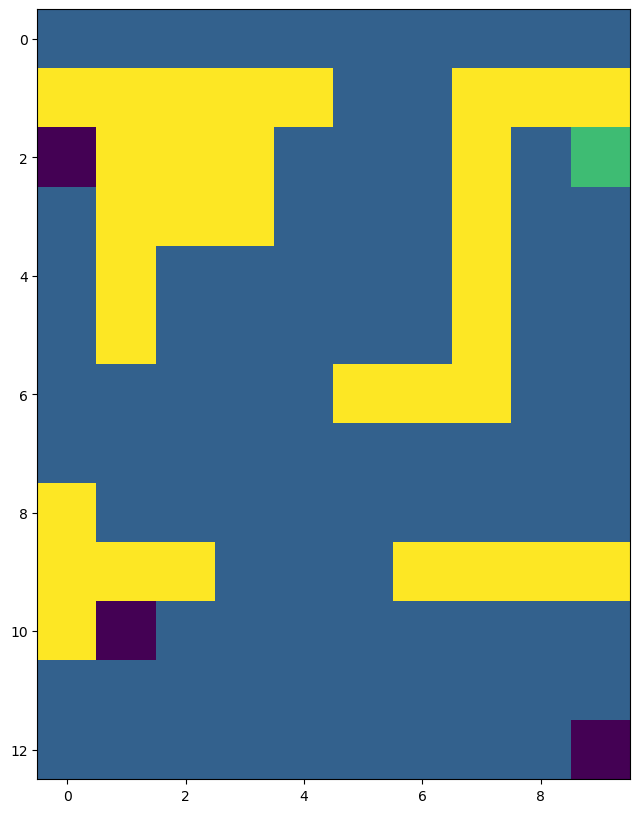

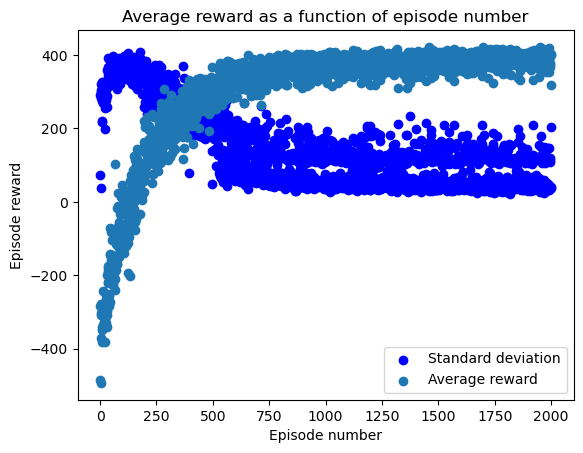

Results of the MC agent:



In [11]:
# Example main (can be edited)

### Question 0: Defining the environment

print("Creating the Maze:\n")
maze = Maze()


### Question 1: Dynamic programming

# dp_agent = DP_agent()
# for prob in np.arange(0, 1, 0.1):
#     maze = Maze(gamma = prob)
#     dp_policy, dp_value = dp_agent.solve(maze)



#     print("Results of the DP agent:\n", maze._prob_success, prob)
#     maze.get_graphics().draw_policy(dp_policy)
#     maze.get_graphics().draw_value(dp_value)


# ## Question 2: Monte-Carlo learning
# means = []
# stds = []
# for epsilon in np.arange(0.1,1,0.1):
#     rwds = []
#     for i in range(10):
#         mc_agent = MC_agent()
#         mc_policy, mc_values, total_rewards = mc_agent.solve(maze)
#         rwds.append(total_rewards)
#     std = np.std(rwds, axis = 0)
#     mean = np.mean(rwds, axis = 0)
#     stds.append(std)
#     means.append(mean)
# mc_agent = MC_agent()
# rwds = []
# for i in range(25):
#     mc_policy, mc_values, total_rewards = mc_agent.solve(maze)
#     rwds.append(total_rewards)
# std = np.std(rwds, axis = 0)
# mean = np.mean(rwds, axis = 0)
plt.scatter(np.arange(len(mean)), std, c='b', label = "Standard deviation")
plt.scatter(np.arange(len(mean)), mean, label = 'Average reward' )
#plt.plot(np.arange(len(mean)), std, c = 'g', label = 'std')
plt.title("Average reward as a function of episode number")
plt.xlabel('Episode number')
plt.ylabel('Episode reward')
plt.legend()

plt.show()

print("Results of the MC agent:\n")
#maze.get_graphics().draw_policy(mc_policy)
#maze.get_graphics().draw_value(mc_values[-1])


### Question 3: Temporal-Difference learning

# td_agent = TD_agent()
# td_policy, td_values, total_rewards = td_agent.solve(maze)

# print("Results of the TD agent:\n")
# maze.get_graphics().draw_policy(td_policy)
# maze.get_graphics().draw_value(td_values[-1])
# plt.plot(np.arange(len(total_rewards)),total_rewards)

In [ ]:
plt.plot(np.arange(len(mean)), mean+std, c='pink', label = "Standard deviation")
plt.plot(np.arange(len(mean)), mean-std, c='pink', label = "Standard deviation")

plt.plot(np.arange(len(mean)), std, label = "Standard deviation")
plt.plot(np.arange(len(mean)), mean, label = 'Average reward' )
plt.title("Average reward as a function of episode number")
plt.xlabel('Episode number')
plt.ylabel('Episode reward')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

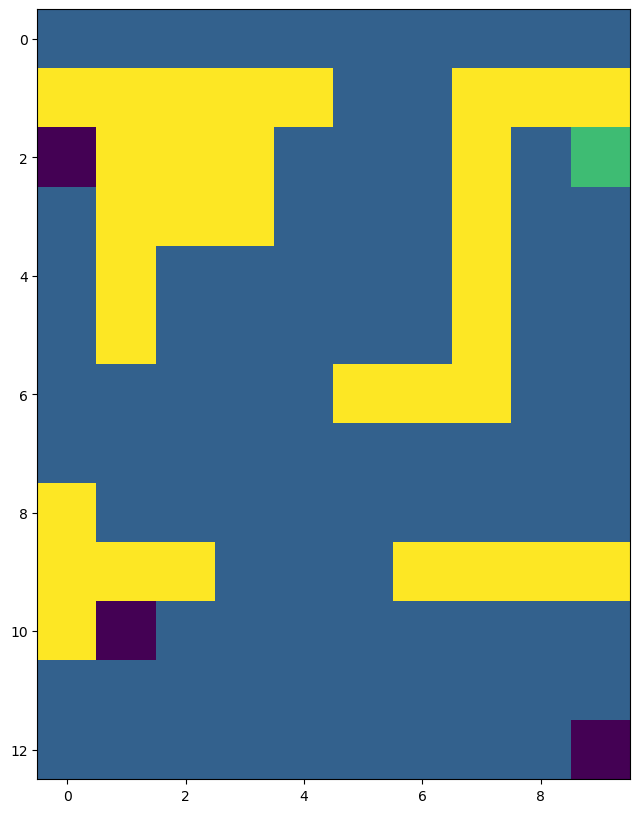

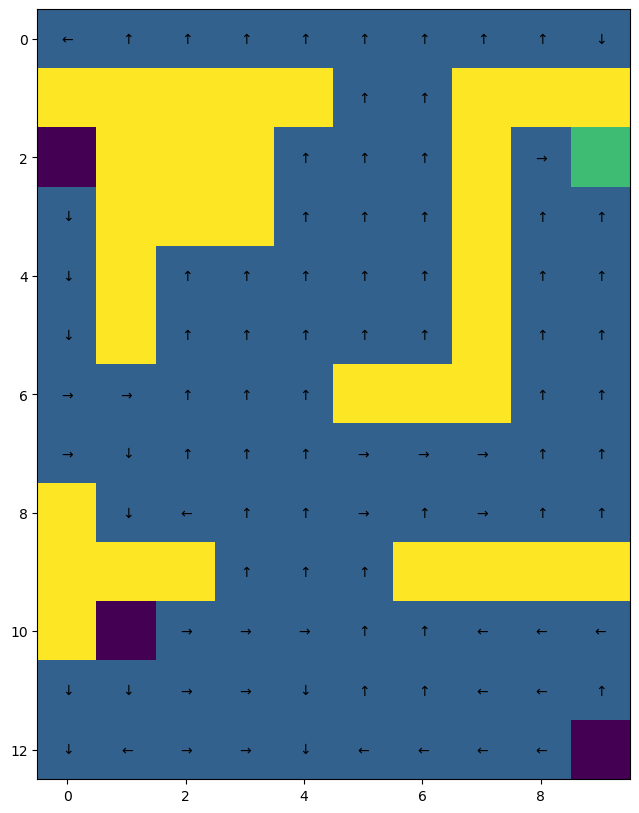

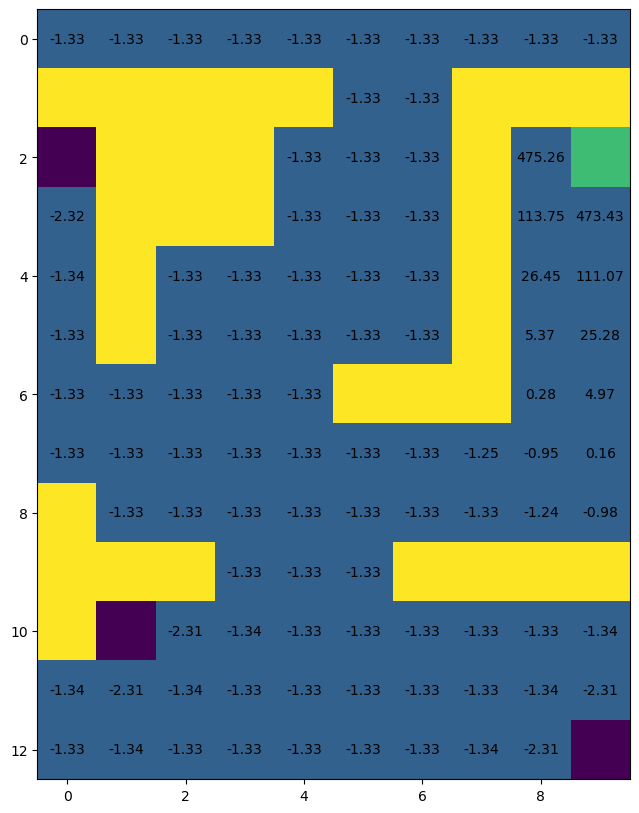

In [ ]:
dp_agent = DP_agent()
maze = Maze(gamma = 0.25)
dp_policy, dp_value = dp_agent.solve(maze)



maze.get_graphics().draw_policy(dp_policy)
maze.get_graphics().draw_value(dp_value)